In [1]:
import tensorflow as tf
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import statsmodels.api as sm
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pickle import dump

from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta

from sklearn.model_selection import KFold

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam

import seaborn as sns

from matplotlib import pyplot
from pickle import load

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
allmodal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Crypto_prediction/allmodal.csv',parse_dates=['time'])
allmodal

,time,high,low,open,volumefrom,volumeto,close,news,Media
0,2021-02-05,38343.92,36626.50,36983.42,45243.69,1.705038e+09,38310.24,19.0,-0.1034
1,2021-02-06,40989.11,38247.96,38310.24,66494.60,2.642530e+09,39267.01,16.0,3.0154
2,2021-02-07,39721.59,37408.16,39267.01,53823.40,2.076905e+09,38868.82,14.0,3.6283
3,2021-02-08,46606.82,38063.87,38868.82,138485.21,5.944522e+09,46437.41,17.0,3.5772
4,2021-02-09,48209.59,45051.46,46437.41,98670.48,4.610215e+09,46509.57,5.0,4.0012
...,...,...,...,...,...,...,...,...,...
754,2023-03-01,23962.77,23037.24,23134.20,45286.75,1.069269e+09,23641.20,67.0,33.0310
755,2023-03-02,23788.72,23212.33,23641.20,34699.93,8.128111e+08,23467.22,67.0,16.6159
756,2023-03-03,23476.96,22147.42,23467.22,59219.77,1.327278e+09,22361.45,51.0,14.4098
757,2023-03-04,22410.72,22179.49,22361.45,11820.44,2.639006e+08,22351.08,44.0,27.0101


In [4]:
allmodal.corr()

<ipython-input-4-a07c22e4b45e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  allmodal.corr()


,high,low,open,volumefrom,volumeto,close,news,Media
high,1.000000,0.995980,0.997995,-0.169301,0.450365,0.997647,-0.585287,0.172785
low,0.995980,1.000000,0.996203,-0.233363,0.382656,0.997384,-0.591547,0.185539
open,0.997995,0.996203,1.000000,-0.184726,0.433884,0.994743,-0.586329,0.177230
volumefrom,-0.169301,-0.233363,-0.184726,1.000000,0.744178,-0.200185,0.039464,-0.185288
volumeto,0.450365,0.382656,0.433884,0.744178,1.000000,0.417855,-0.323714,-0.133513
close,0.997647,0.997384,0.994743,-0.200185,0.417855,1.000000,-0.589031,0.179589
news,-0.585287,-0.591547,-0.586329,0.039464,-0.323714,-0.589031,1.000000,0.047804
Media,0.172785,0.185539,0.177230,-0.185288,-0.133513,0.179589,0.047804,1.000000


<ipython-input-5-7608eb8f5987>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataplot = sns.heatmap(allmodal.corr(), cmap="YlGnBu", annot=True)


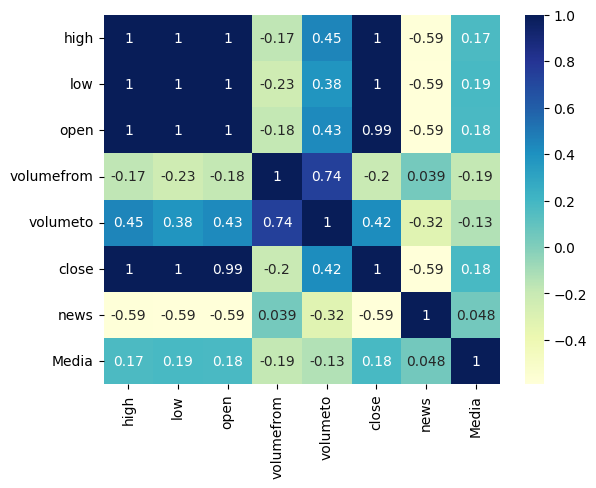

In [5]:
dataplot = sns.heatmap(allmodal.corr(), cmap="YlGnBu", annot=True)

# displaying heatmap
plt.show()

In [6]:
allmodal = allmodal.set_index('time')
allmodal.index = pd.to_datetime(allmodal.index)

In [179]:
df_BTC_ext = allmodal.copy()
df_BTC_ext['Prediction'] = df_BTC_ext['close']
df_BTC_ext.head()

,high,low,open,volumefrom,volumeto,close,news,Media,Prediction
time,,,,,,,,,
2021-02-05,38343.92,36626.50,36983.42,45243.69,1.705038e+09,38310.24,19.0,-0.1034,38310.24
2021-02-06,40989.11,38247.96,38310.24,66494.60,2.642530e+09,39267.01,16.0,3.0154,39267.01
2021-02-07,39721.59,37408.16,39267.01,53823.40,2.076905e+09,38868.82,14.0,3.6283,38868.82
2021-02-08,46606.82,38063.87,38868.82,138485.21,5.944522e+09,46437.41,17.0,3.5772,46437.41
2021-02-09,48209.59,45051.46,46437.41,98670.48,4.610215e+09,46509.57,5.0,4.0012,46509.57


In [180]:
# Get the number of rows in the data
nrows = allmodal.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(allmodal)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(df_BTC_ext['close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(759, 8)


In [192]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 12

# Prediction Index
index_Close = allmodal.columns.get_loc("close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 70% of the data
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.7)
val_data_len = math.ceil(np_data_scaled.shape[0] * 0.2)
# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len:train_data_len+val_data_len, :]
val_data = np_data_scaled[train_data_len+val_data_len:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)
x_val, y_val = partition_dataset(sequence_length, val_data)
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(520, 12, 8) (520,)
(140, 12, 8) (140,)
(63, 12, 8) (63,)
0.7027506833021331
0.7027506833021331


In [129]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

96 12 8


In [130]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 12, 96)            40320     
                                                                 
 lstm_63 (LSTM)              (None, 96)                74112     
                                                                 
 dense_58 (Dense)            (None, 5)                 485       
                                                                 
 dense_59 (Dense)            (None, 1)                 6         
                                                                 
Total params: 114,923
Trainable params: 114,923
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Cross-validation
cvscores = []
kfold = KFold(n_splits=3, shuffle=True)
results = []
for train_index, test_index in kfold.split(x_train):
    # Train the model
    model.fit(x_train[train_index], y_train[train_index], epochs=20, batch_size=15)
    # Evaluate the model
    scores = model.evaluate(x_test, y_test, verbose=0)
    print(scores)
    cvscores.append(scores *100)

print("%.6f%% (+/- %.6f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [132]:
ypred_scaled = model.predict(x_val)
y_pred = scaler_pred.inverse_transform(ypred_scaled)
y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

2/2 [==============================] - 1s 13ms/step
Median Absolute Error (MAE): 837.6
Mean Absolute Percentage Error (MAPE): 3.77 %
Median Absolute Percentage Error (MDAPE): 3.07 %


In [196]:
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Concatenate, Dot, Activation
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model

# Input layer for the CNN-LSTM model
input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))

# CNN layers for spatial feature extraction
cnn_layer = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
cnn_layer = Flatten()(cnn_layer)

# LSTM layer for sequence processing
lstm_layer = LSTM(n_neurons, return_sequences=True)(input_layer)
lstm_layer = LSTM(n_neurons, return_sequences=False)(lstm_layer)

# Concatenate CNN output with LSTM output
combined = Concatenate(axis=-1)([cnn_layer, lstm_layer])

# Final prediction layer
output_layer = Dense(5)(combined)
output_layer = Dense(1)(output_layer)

# Create the CNN-LSTM model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 12, 8)]      0           []                               
                                                                                                  
 conv1d_17 (Conv1D)             (None, 10, 32)       800         ['input_25[0][0]']               
                                                                                                  
 max_pooling1d_17 (MaxPooling1D  (None, 5, 32)       0           ['conv1d_17[0][0]']              
 )                                                                                                
                                                                                                  
 lstm_101 (LSTM)                (None, 12, 96)       40320       ['input_25[0][0]']        

In [197]:
# Cross-validation
cvscores = []
kfold = KFold(n_splits=3, shuffle=True)
results = []
for train_index, test_index in kfold.split(x_train):
    # Train the model
    model.fit(x_train[train_index], y_train[train_index], epochs=20, batch_size=15)
    # Evaluate the model
    scores = model.evaluate(x_test, y_test, verbose=0)
    print(scores)
    cvscores.append(scores *100)

print("%.6f%% (+/- %.6f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/20
24/24 [==============================] - 6s 31ms/step - loss: 0.0393
Epoch 2/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0069
Epoch 3/20
24/24 [==============================] - 1s 30ms/step - loss: 0.0054
Epoch 4/20
24/24 [==============================] - 1s 22ms/step - loss: 0.0051
Epoch 5/20
24/24 [==============================] - 0s 18ms/step - loss: 0.0042
Epoch 6/20
24/24 [==============================] - 0s 17ms/step - loss: 0.0049
Epoch 7/20
24/24 [==============================] - 0s 18ms/step - loss: 0.0040
Epoch 8/20
24/24 [==============================] - 0s 18ms/step - loss: 0.0035
Epoch 9/20
24/24 [==============================] - 0s 18ms/step - loss: 0.0034
Epoch 10/20
24/24 [==============================] - 0s 18ms/step - loss: 0.0031
Epoch 11/20
24/24 [==============================] - 0s 17ms/step - loss: 0.0030
Epoch 12/20
24/24 [==============================] - 0s 18ms/step - loss: 0.0030
Epoch 13/20
24/24 [==================

In [198]:
ypred_scaled = model.predict(x_val)
y_pred = scaler_pred.inverse_transform(ypred_scaled)
y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

2/2 [==============================] - 1s 12ms/step
Median Absolute Error (MAE): 908.86
Mean Absolute Percentage Error (MAPE): 4.17 %
Median Absolute Percentage Error (MDAPE): 3.43 %


### One-modal

In [104]:
onemodal = allmodal.drop(columns=['news','Media'])
onemodal

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-02-05,38343.92,36626.50,36983.42,45243.69,1.705038e+09,38310.24
2021-02-06,40989.11,38247.96,38310.24,66494.60,2.642530e+09,39267.01
2021-02-07,39721.59,37408.16,39267.01,53823.40,2.076905e+09,38868.82
2021-02-08,46606.82,38063.87,38868.82,138485.21,5.944522e+09,46437.41
2021-02-09,48209.59,45051.46,46437.41,98670.48,4.610215e+09,46509.57
...,...,...,...,...,...,...
2023-03-01,23962.77,23037.24,23134.20,45286.75,1.069269e+09,23641.20
2023-03-02,23788.72,23212.33,23641.20,34699.93,8.128111e+08,23467.22
2023-03-03,23476.96,22147.42,23467.22,59219.77,1.327278e+09,22361.45


In [171]:
df_BTC_ext2 = onemodal.copy()
df_BTC_ext2['Prediction'] = df_BTC_ext2['close']
df_BTC_ext2.head()

,high,low,open,volumefrom,volumeto,close,Prediction
time,,,,,,,
2021-02-05,38343.92,36626.50,36983.42,45243.69,1.705038e+09,38310.24,38310.24
2021-02-06,40989.11,38247.96,38310.24,66494.60,2.642530e+09,39267.01,39267.01
2021-02-07,39721.59,37408.16,39267.01,53823.40,2.076905e+09,38868.82,38868.82
2021-02-08,46606.82,38063.87,38868.82,138485.21,5.944522e+09,46437.41,46437.41
2021-02-09,48209.59,45051.46,46437.41,98670.48,4.610215e+09,46509.57,46509.57


In [172]:
# Get the number of rows in the data
nrows = onemodal.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(onemodal)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(df_BTC_ext2['close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(759, 6)


In [173]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 14

# Prediction Index
index_Close = onemodal.columns.get_loc("close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 70% of the data
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.7)
val_data_len = math.ceil(np_data_scaled.shape[0] * 0.2)
# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len:train_data_len+val_data_len, :]
val_data = np_data_scaled[train_data_len+val_data_len:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)
x_val, y_val = partition_dataset(sequence_length, val_data)
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(518, 14, 6) (518,)
(138, 14, 6) (138,)
(61, 14, 6) (61,)
0.7757114210656908
0.7757114210656908


In [108]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

84 14 6
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 14, 84)            30576     
                                                                 
 lstm_53 (LSTM)              (None, 84)                56784     
                                                                 
 dense_48 (Dense)            (None, 5)                 425       
                                                                 
 dense_49 (Dense)            (None, 1)                 6         
                                                                 
Total params: 87,791
Trainable params: 87,791
Non-trainable params: 0
_________________________________________________________________


In [109]:
# Cross-validation
cvscores = []
kfold = KFold(n_splits=3, shuffle=True)
results = []
for train_index, test_index in kfold.split(x_train):
    # Train the model
    model.fit(x_train[train_index], y_train[train_index], epochs=10, batch_size=15)
    # Evaluate the model
    scores = model.evaluate(x_test, y_test, verbose=0)
    print(scores)
    cvscores.append(scores *100)

print("%.6f%% (+/- %.6f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/10
23/23 [==============================] - 4s 28ms/step - loss: 0.0352
Epoch 2/10
23/23 [==============================] - 1s 28ms/step - loss: 0.0062
Epoch 3/10
23/23 [==============================] - 1s 27ms/step - loss: 0.0049
Epoch 4/10
23/23 [==============================] - 1s 25ms/step - loss: 0.0042
Epoch 5/10
23/23 [==============================] - 1s 25ms/step - loss: 0.0042
Epoch 6/10
23/23 [==============================] - 1s 24ms/step - loss: 0.0039
Epoch 7/10
23/23 [==============================] - 1s 25ms/step - loss: 0.0036
Epoch 8/10
23/23 [==============================] - 0s 21ms/step - loss: 0.0035
Epoch 9/10
23/23 [==============================] - 0s 17ms/step - loss: 0.0034
Epoch 10/10
23/23 [==============================] - 0s 17ms/step - loss: 0.0031
0.0003808072942774743
Epoch 1/10
23/23 [==============================] - 0s 18ms/step - loss: 0.0033
Epoch 2/10
23/23 [==============================] - 0s 18ms/step - loss: 0.0030
Epoch 3/10
23/23 

In [110]:
ypred_scaled = model.predict(x_val)
y_pred = scaler_pred.inverse_transform(ypred_scaled)
y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

2/2 [==============================] - 1s 11ms/step
Median Absolute Error (MAE): 863.63
Mean Absolute Percentage Error (MAPE): 3.92 %
Median Absolute Percentage Error (MDAPE): 2.25 %


In [176]:
# Input layer for the CNN-LSTM model
input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))

# CNN layers for spatial feature extraction
cnn_layer = Conv1D(filters=16, kernel_size=3, activation='relu')(input_layer)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
cnn_layer = Flatten()(cnn_layer)

# LSTM layer for sequence processing
lstm_layer = LSTM(n_neurons, return_sequences=True)(input_layer)
lstm_layer = LSTM(n_neurons, return_sequences=False)(lstm_layer)

# Concatenate CNN output with LSTM output
combined = Concatenate(axis=-1)([cnn_layer, lstm_layer])

# Final prediction layer
output_layer = Dense(5)(combined)
output_layer = Dense(1)(output_layer)

# Create the CNN-LSTM model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 14, 6)]      0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 12, 16)       304         ['input_20[0][0]']               
                                                                                                  
 max_pooling1d_12 (MaxPooling1D  (None, 6, 16)       0           ['conv1d_12[0][0]']              
 )                                                                                                
                                                                                                  
 lstm_91 (LSTM)                 (None, 14, 96)       39552       ['input_20[0][0]']        

In [177]:
# Cross-validation
cvscores = []
kfold = KFold(n_splits=3, shuffle=True)
results = []
for train_index, test_index in kfold.split(x_train):
    # Train the model
    model.fit(x_train[train_index], y_train[train_index], epochs=20, batch_size=15)
    # Evaluate the model
    scores = model.evaluate(x_test, y_test, verbose=0)
    print(scores)
    cvscores.append(scores *100)

print("%.6f%% (+/- %.6f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/20
23/23 [==============================] - 4s 20ms/step - loss: 0.0589
Epoch 2/20
23/23 [==============================] - 0s 20ms/step - loss: 0.0066
Epoch 3/20
23/23 [==============================] - 0s 19ms/step - loss: 0.0054
Epoch 4/20
23/23 [==============================] - 1s 23ms/step - loss: 0.0052
Epoch 5/20
23/23 [==============================] - 1s 29ms/step - loss: 0.0046
Epoch 6/20
23/23 [==============================] - 1s 29ms/step - loss: 0.0043
Epoch 7/20
23/23 [==============================] - 1s 29ms/step - loss: 0.0041
Epoch 8/20
23/23 [==============================] - 1s 29ms/step - loss: 0.0039
Epoch 9/20
23/23 [==============================] - 1s 29ms/step - loss: 0.0038
Epoch 10/20
23/23 [==============================] - 1s 29ms/step - loss: 0.0036
Epoch 11/20
23/23 [==============================] - 1s 23ms/step - loss: 0.0034
Epoch 12/20
23/23 [==============================] - 0s 19ms/step - loss: 0.0034
Epoch 13/20
23/23 [==================

In [178]:
ypred_scaled = model.predict(x_val)
y_pred = scaler_pred.inverse_transform(ypred_scaled)
y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

2/2 [==============================] - 4s 17ms/step
Median Absolute Error (MAE): 887.65
Mean Absolute Percentage Error (MAPE): 4.03 %
Median Absolute Percentage Error (MDAPE): 3.12 %


### Two modals (news)

In [36]:
newsmodal = allmodal.drop(columns='Media')
newsmodal

,high,low,open,volumefrom,volumeto,close,news
time,,,,,,,
2021-02-05,38343.92,36626.50,36983.42,45243.69,1.705038e+09,38310.24,19.0
2021-02-06,40989.11,38247.96,38310.24,66494.60,2.642530e+09,39267.01,16.0
2021-02-07,39721.59,37408.16,39267.01,53823.40,2.076905e+09,38868.82,14.0
2021-02-08,46606.82,38063.87,38868.82,138485.21,5.944522e+09,46437.41,17.0
2021-02-09,48209.59,45051.46,46437.41,98670.48,4.610215e+09,46509.57,5.0
...,...,...,...,...,...,...,...
2023-03-01,23962.77,23037.24,23134.20,45286.75,1.069269e+09,23641.20,67.0
2023-03-02,23788.72,23212.33,23641.20,34699.93,8.128111e+08,23467.22,67.0
2023-03-03,23476.96,22147.42,23467.22,59219.77,1.327278e+09,22361.45,51.0


In [111]:
df_BTC_ext3 = newsmodal.copy()
df_BTC_ext3['Prediction'] = df_BTC_ext3['close']
df_BTC_ext3.head()

,high,low,open,volumefrom,volumeto,close,news,Prediction
time,,,,,,,,
2021-02-05,38343.92,36626.50,36983.42,45243.69,1.705038e+09,38310.24,19.0,38310.24
2021-02-06,40989.11,38247.96,38310.24,66494.60,2.642530e+09,39267.01,16.0,39267.01
2021-02-07,39721.59,37408.16,39267.01,53823.40,2.076905e+09,38868.82,14.0,38868.82
2021-02-08,46606.82,38063.87,38868.82,138485.21,5.944522e+09,46437.41,17.0,46437.41
2021-02-09,48209.59,45051.46,46437.41,98670.48,4.610215e+09,46509.57,5.0,46509.57


In [112]:
# Get the number of rows in the data
nrows = newsmodal.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(newsmodal)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(df_BTC_ext3['close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(759, 7)


In [113]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 12

# Prediction Index
index_Close = newsmodal.columns.get_loc("close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 70% of the data
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.7)
val_data_len = math.ceil(np_data_scaled.shape[0] * 0.2)
# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len:train_data_len+val_data_len, :]
val_data = np_data_scaled[train_data_len+val_data_len:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)
x_val, y_val = partition_dataset(sequence_length, val_data)
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(520, 12, 7) (520,)
(140, 12, 7) (140,)
(63, 12, 7) (63,)
0.7027506833021331
0.7027506833021331


In [118]:
from keras.layers import LSTM, Dense, Input, Concatenate, Dot, Activation, Multiply
from keras.models import Model

n_neurons = x_train.shape[1] * x_train.shape[2]
# Input layer with specified shape
input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))

# LSTM layer with return_sequences=True to produce outputs for each time step
lstm_out = LSTM(n_neurons, return_sequences=True)(input_layer)

# Attention Mechanism
# We compute attention weights by learning a set of weights for each time step and then normalizing them.
attention_probs = Dense(x_train.shape[1], activation='softmax', name='attention_probs')(lstm_out)

# Apply the attention weights to the LSTM outputs to obtain the context vector
context_vector = Dot(axes=1)([attention_probs, lstm_out])

# Concatenate the context vector with the LSTM output
attention_output = Concatenate(axis=-1)([context_vector, lstm_out])

# Final LSTM layer with return_sequences=False
lstm_out_final = LSTM(n_neurons, return_sequences=False)(attention_output)

# Dense layers for predictions
dense_layer1 = Dense(6, activation='relu')(lstm_out_final)
output_layer = Dense(1)(dense_layer1)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 12, 7)]      0           []                               
                                                                                                  
 lstm_58 (LSTM)                 (None, 12, 84)       30912       ['input_3[0][0]']                
                                                                                                  
 attention_probs (Dense)        (None, 12, 12)       1020        ['lstm_58[0][0]']                
                                                                                                  
 dot_2 (Dot)                    (None, 12, 84)       0           ['attention_probs[0][0]',        
                                                                  'lstm_58[0][0]']          

In [101]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(3))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

84 12 7
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 12, 84)            30912     
                                                                 
 lstm_51 (LSTM)              (None, 84)                56784     
                                                                 
 dense_46 (Dense)            (None, 3)                 255       
                                                                 
 dense_47 (Dense)            (None, 1)                 4         
                                                                 
Total params: 87,955
Trainable params: 87,955
Non-trainable params: 0
_________________________________________________________________


In [119]:
# Cross-validation
cvscores = []
kfold = KFold(n_splits=3, shuffle=True)
results = []
for train_index, test_index in kfold.split(x_train):
    # Train the model
    model.fit(x_train[train_index], y_train[train_index], epochs=20, batch_size=15)
    # Evaluate the model
    scores = model.evaluate(x_test, y_test, verbose=0)
    print(scores)
    cvscores.append(scores *100)

print("%.6f%% (+/- %.6f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/20
24/24 [==============================] - 5s 22ms/step - loss: 0.0334
Epoch 2/20
24/24 [==============================] - 1s 21ms/step - loss: 0.0062
Epoch 3/20
24/24 [==============================] - 1s 21ms/step - loss: 0.0047
Epoch 4/20
24/24 [==============================] - 1s 23ms/step - loss: 0.0049
Epoch 5/20
24/24 [==============================] - 1s 22ms/step - loss: 0.0046
Epoch 6/20
24/24 [==============================] - 1s 22ms/step - loss: 0.0042
Epoch 7/20
24/24 [==============================] - 1s 21ms/step - loss: 0.0055
Epoch 8/20
24/24 [==============================] - 1s 22ms/step - loss: 0.0036
Epoch 9/20
24/24 [==============================] - 0s 20ms/step - loss: 0.0043
Epoch 10/20
24/24 [==============================] - 1s 21ms/step - loss: 0.0031
Epoch 11/20
24/24 [==============================] - 0s 21ms/step - loss: 0.0032
Epoch 12/20
24/24 [==============================] - 1s 21ms/step - loss: 0.0036
Epoch 13/20
24/24 [==================

In [120]:
ypred_scaled = model.predict(x_val)
y_pred = scaler_pred.inverse_transform(ypred_scaled)
y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

2/2 [==============================] - 1s 13ms/step
Median Absolute Error (MAE): 1264.96
Mean Absolute Percentage Error (MAPE): 5.94 %
Median Absolute Percentage Error (MDAPE): 5.45 %
